## Notebook for pytorch classification exercises
https://www.learnpytorch.io/02_pytorch_classification/#exercises

1. Make a binary classification dataset with Scikit-Learn's `make_moons()` function.
* For consistency, the dataset should have 1000 samples and a `random_state=42`.
* Turn the data into PyTorch tensors. Split the data into training and test sets using `train_test_split` with 80% training and 20% testing.

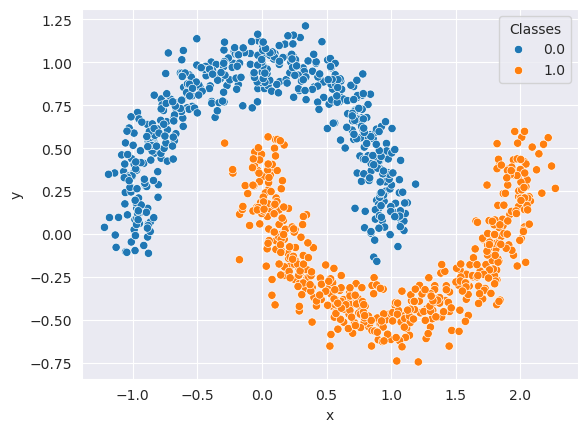

In [239]:
import torch
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
from torchmetrics.classification import BinaryAccuracy
from torchmetrics.classification import MulticlassAccuracy
import numpy as np

RANDOM_SEED = 42
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

X, y = make_moons(n_samples=1000, random_state=RANDOM_SEED, shuffle=True, noise=0.1)
X = torch.tensor(X).type(torch.float)
y = torch.tensor(y).type(torch.float)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

ax = sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=y)
ax.set(xlabel='x', ylabel='y')
plt.legend(title='Classes')
pass

2. Build a model by subclassing `nn.Module` that incorporates non-linear activation functions and is capable of fitting the data you created in 1.
* Feel free to use any combination of PyTorch layers (linear and non-linear) you want.

In [240]:
class MoonModel(torch.nn.Module):
    def __init__(self):
        super(MoonModel, self).__init__()
        self.linear_stack = torch.nn.Sequential(
            torch.nn.Linear(2, 8),
            torch.nn.ReLU(),
            torch.nn.Linear(8, 1),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.linear_stack(x)

3. Setup a binary classification compatible loss function and optimizer to use when training the model.

In [241]:
torch.manual_seed(RANDOM_SEED)
moon_model = MoonModel().to(DEVICE)

loss_fn = torch.nn.BCEWithLogitsLoss()
optim = torch.optim.SGD(params=moon_model.parameters(), lr=0.5)

4. Create a training and testing loop to fit the model you created in 2 to the data you created in 1.
* To measure model accuracy, you can create your own accuracy function or use the accuracy function in `TorchMetrics`.
* Train the model for long enough for it to reach over 96% accuracy.
* The training loop should output progress every 10 epochs of the model's training and test set loss and accuracy.

In [242]:
epochs = 1000

for epoch in range(epochs):
    moon_model.train()

    y_logits = moon_model(X_train.to(DEVICE))
    train_loss = loss_fn(y_logits.squeeze(), y_train.to(DEVICE))
    optim.zero_grad()
    train_loss.backward()
    optim.step()

    if epoch % 10 == 0:
        moon_model.eval()
        with torch.inference_mode():
            y_logits = moon_model(X_test.to(DEVICE))
        test_loss = loss_fn(y_logits.squeeze(), y_test.to(DEVICE))
        y_preds = torch.sigmoid(y_logits.squeeze())
        accuracy = BinaryAccuracy().to(DEVICE)
        print(f'epoch: {epoch}, train_loss: {train_loss}, test_loss: {test_loss}, accuracy: {accuracy(y_preds, y_test.to(DEVICE))}')

epoch: 0, train_loss: 0.7165105938911438, test_loss: 0.6521590352058411, accuracy: 0.6899999976158142
epoch: 10, train_loss: 0.4298039972782135, test_loss: 0.38697341084480286, accuracy: 0.8700000047683716
epoch: 20, train_loss: 0.3436345160007477, test_loss: 0.29949960112571716, accuracy: 0.875
epoch: 30, train_loss: 0.31360146403312683, test_loss: 0.2695881128311157, accuracy: 0.8799999952316284
epoch: 40, train_loss: 0.29624950885772705, test_loss: 0.2538717985153198, accuracy: 0.8949999809265137
epoch: 50, train_loss: 0.28445249795913696, test_loss: 0.24355006217956543, accuracy: 0.9049999713897705
epoch: 60, train_loss: 0.2753102481365204, test_loss: 0.23556765913963318, accuracy: 0.9100000262260437
epoch: 70, train_loss: 0.26770204305648804, test_loss: 0.228590190410614, accuracy: 0.9150000214576721
epoch: 80, train_loss: 0.26109325885772705, test_loss: 0.22267283499240875, accuracy: 0.9150000214576721
epoch: 90, train_loss: 0.25561392307281494, test_loss: 0.21762043237686157, ac

5. Make predictions with your trained model and plot them using the `plot_decision_boundary()` function created in this notebook.

In [243]:
def plot_decision_boundary(model: torch.nn.Module, X: torch.Tensor, y: torch.Tensor):
    """Plots decision boundaries of model predicting on X in comparison to y.

    Source - https://madewithml.com/courses/foundations/neural-networks/ (with modifications)
    """
    # Put everything to CPU (works better with NumPy + Matplotlib)
    model.to("cpu")
    X_plot, y_plot = X.to("cpu"), y.to("cpu")

    # Setup prediction boundaries and grid
    x_min, x_max = X_plot[:, 0].min() - 0.1, X_plot[:, 0].max() + 0.1
    y_min, y_max = X_plot[:, 1].min() - 0.1, X_plot[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101))

    # Make features
    X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).float()

    # Make predictions
    model.eval()
    with torch.inference_mode():
        y_logits = model(X_to_pred_on)

    # Test for multi-class or binary and adjust logits to prediction labels
    if len(torch.unique(y_plot)) > 2:
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)  # mutli-class
    else:
        y_pred = torch.round(torch.sigmoid(y_logits))  # binary

    # Reshape preds and plot
    y_pred = y_pred.reshape(xx.shape).detach().numpy()
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    ax = sns.scatterplot(x=X_plot[:, 0], y=X_plot[:, 1], hue=y_plot.squeeze())
    ax.set(xlabel='x', ylabel='y')
    plt.legend(title='Classes')
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

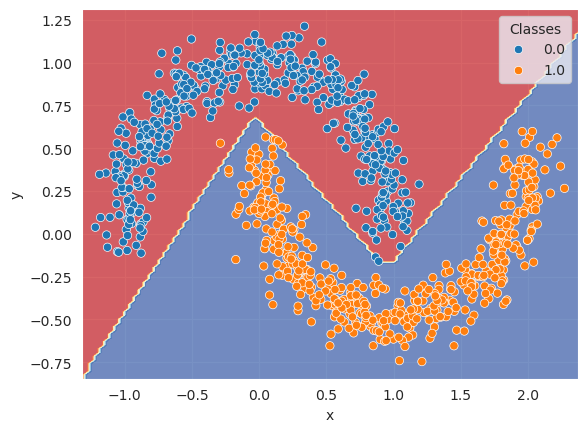

In [244]:
plot_decision_boundary(moon_model, X, y)

6. Replicate the Tanh (hyperbolic tangent) activation function in pure PyTorch

In [245]:
def tanh(x: torch.Tensor) -> torch.Tensor:
    return (torch.exp(x) - torch.exp(-x)) / (torch.exp(x) + torch.exp(-x))

7. Create a multi-class dataset using the spirals data creation function from CS231n (see below for the code).
* Construct a model capable of fitting the data (you may need a combination of linear and non-linear layers).
* Build a loss function and optimizer capable of handling multi-class data (optional extension: use the Adam optimizer instead of SGD, you may have to experiment with different values of the learning rate to get it working).
* Make a training and testing loop for the multi-class data and train a model on it to reach over 95% testing accuracy (you can use any accuracy measuring function here that you like).
* Plot the decision boundaries on the spirals dataset from your model predictions, the `plot_decision_boundary()` function should work for this dataset too.

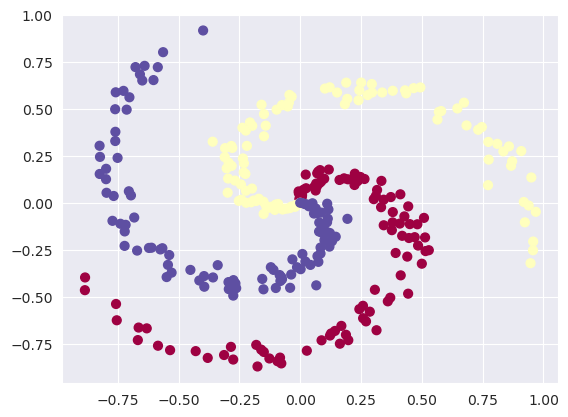

In [246]:
N = 100 # number of points per class
D = 2 # dimensionality
K = 3 # number of classes
X = np.zeros((N*K,D)) # data matrix (each row = single example)
y = np.zeros(N*K, dtype='uint8') # class labels
for j in range(K):
  ix = range(N*j,N*(j+1))
  r = np.linspace(0.0,1,N) # radius
  t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2 # theta
  X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
  y[ix] = j
# lets visualize the data
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.show()

In [247]:
class SpiralModel(torch.nn.Module):
    def __init__(self):
        super(SpiralModel, self).__init__()
        self.layer_stack = torch.nn.Sequential(
            torch.nn.Linear(2, 16),
            torch.nn.ReLU(),
            torch.nn.Linear(16, 16),
            torch.nn.ReLU(),
            torch.nn.Linear(16, 3),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.layer_stack(x)

In [248]:
spiral_model = SpiralModel().to(DEVICE)

loss_fn = torch.nn.CrossEntropyLoss()
optim = torch.optim.Adam(params=spiral_model.parameters(), lr=0.1)

X = torch.tensor(X).type(torch.float)
y = torch.tensor(y).type(torch.long)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [249]:
epochs = 100

for epoch in range(epochs):
    spiral_model.to(DEVICE)
    spiral_model.train()

    y_logits = spiral_model(X_train.to(DEVICE)).squeeze()
    train_loss = loss_fn(y_logits, y_train.to(DEVICE))
    optim.zero_grad()
    train_loss.backward()
    optim.step()

    if epoch % 10 == 0:
        spiral_model.eval()
        with torch.inference_mode():
            y_logits = spiral_model(X_test.to(DEVICE))
        y_preds = torch.softmax(y_logits, dim=1).argmax(dim=1)
        test_loss = loss_fn(y_logits.squeeze(), y_test.to(DEVICE))
        accuracy = MulticlassAccuracy(num_classes=3).to(DEVICE)
        print(f'epoch: {epoch}, train_loss: {train_loss}, test_loss: {test_loss}, accuracy: {accuracy(y_preds, y_test.to(DEVICE))}')

epoch: 0, train_loss: 1.1020023822784424, test_loss: 1.182597041130066, accuracy: 0.3333333432674408
epoch: 10, train_loss: 0.7916840314865112, test_loss: 0.7800979614257812, accuracy: 0.5801083445549011
epoch: 20, train_loss: 0.5781921148300171, test_loss: 0.5162498354911804, accuracy: 0.7493119835853577
epoch: 30, train_loss: 0.3257288634777069, test_loss: 0.27680855989456177, accuracy: 0.8783109188079834
epoch: 40, train_loss: 0.1328781396150589, test_loss: 0.11666270345449448, accuracy: 0.9824562072753906
epoch: 50, train_loss: 0.06802142411470413, test_loss: 0.0661396011710167, accuracy: 0.9824562072753906
epoch: 60, train_loss: 0.03999731317162514, test_loss: 0.059188637882471085, accuracy: 0.9628483057022095
epoch: 70, train_loss: 0.03062223084270954, test_loss: 0.06882452219724655, accuracy: 0.9628483057022095
epoch: 80, train_loss: 0.02561812475323677, test_loss: 0.0659831091761589, accuracy: 0.9628483057022095
epoch: 90, train_loss: 0.022467322647571564, test_loss: 0.05319669

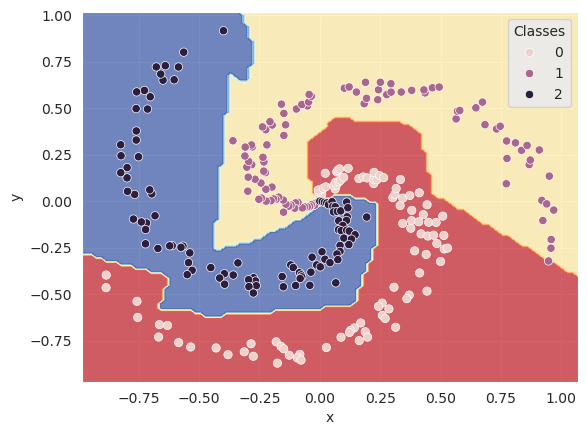

In [250]:
plot_decision_boundary(spiral_model, X, y)